In [1]:
# cargo las librerias que necesito
if(!require("data.table")) install.packages("data.table")
require("data.table")

if(!require("parallel")) install.packages("parallel")
require("parallel")

if(!require("R.utils")) install.packages("R.utils")
require("R.utils")

if( !require("primes") ) install.packages("primes")
require("primes")

if( !require("utils") ) install.packages("utils")
require("utils")

if( !require("rlist") ) install.packages("rlist")
require("rlist")

if( !require("yaml")) install.packages("yaml")
require("yaml")

if( !require("lightgbm") ) install.packages("lightgbm")
require("lightgbm")

if( !require("DiceKriging") ) install.packages("DiceKriging")
require("DiceKriging")

if( !require("mlrMBO") ) install.packages("mlrMBO")
require("mlrMBO")

if( !require("ggplot2") ) install.packages("ggplot2")
require("ggplot2")

Cargando paquete requerido: data.table

Cargando paquete requerido: parallel

Cargando paquete requerido: R.utils

Cargando paquete requerido: R.oo

Cargando paquete requerido: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


Adjuntando el paquete: 'R.oo'


The following object is masked from 'package:R.methodsS3':

    throw


The following objects are masked from 'package:methods':

    getClasses, getMethods


The following objects are masked from 'package:base':

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.


Adjuntando el paquete: 'R.utils'


The following object is masked from 'package:utils':

    timestamp


The following objects are masked from 'package:base':

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings


Cargando paquete requerido: prime

In [2]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2336750,124.8,4765421,254.6,2934765,156.8
Vcells,4043417,30.9,8388608,64.0,5870691,44.8


# Parámetros

In [3]:
# Parámetros
PARAM <- list()
PARAM$experimento <- "expC01_Prueba01_A"
PARAM$semilla_primigenia <- 200003

# training y future
PARAM$train <- c(202101, 202102)
PARAM$train_final <- c(202101, 202102)
PARAM$future <- c(202104)
PARAM$train_final_kaggle <- c(202101, 202102, 202103, 202104)
PARAM$entrega_kaggle <- c(202106)
PARAM$semilla_kaggle <- 314159 #Semilla para el modelo final que va a Kaggle, primeros números de pi que sean primos.
PARAM$cortes <- seq(0, 20000, by= 100)

# un undersampling de 0.1  toma solo el 10% de los CONTINUA
# undersampling de 1.0  implica tomar TODOS los datos

PARAM$trainingstrategy$undersampling <- 0.5

# Parametros LightGBM

PARAM$hyperparametertuning$xval_folds <- 5

# parametros fijos del LightGBM que se pisaran con la parte variable de la BO
PARAM$lgbm$param_fijos <-  list(
  boosting= "gbdt", # puede ir dart, ni pruebe random_forest
  objective= "binary", #default regression
  metric= "auc", # default "" 
  first_metric_only= FALSE, # default FALSE
  boost_from_average= TRUE, # default TRUE
  feature_pre_filter= FALSE, # default TRUE
  force_row_wise= TRUE, # para reducir warnings
  verbosity= -100, # default 1

  seed= PARAM$semilla_primigenia, # Relacionado con data_random_seed, feature_fraction_seed, entre otros 

  max_depth= -1L, # -1 significa no limitar,  por ahora lo dejo fijo
  min_gain_to_split= 0, # min_gain_to_split >= 0
  min_sum_hessian_in_leaf= 0.001, #  min_sum_hessian_in_leaf >= 0.0
  lambda_l1= 0.0, # lambda_l1 >= 0.0
  lambda_l2= 0.0, # lambda_l2 >= 0.0
  max_bin= 31L, # lo debo dejar fijo, no participa de la BO

  bagging_fraction= 1.0, # 0.0 < bagging_fraction <= 1.0
  pos_bagging_fraction= 1.0, # 0.0 < pos_bagging_fraction <= 1.0
  neg_bagging_fraction= 1.0, # 0.0 < neg_bagging_fraction <= 1.0
  is_unbalance= FALSE, # Default FALSE
  scale_pos_weight= 1.0, # scale_pos_weight > 0.0

  drop_rate= 0.1, # 0.0 < neg_bagging_fraction <= 1.0
  max_drop= 50, # <=0 means no limit
  skip_drop= 0.5, # 0.0 <= skip_drop <= 1.0

  extra_trees= FALSE, # default FALSE

  num_iterations= 1200, # default 100
  learning_rate= 0.02, # default 0.1
  feature_fraction= 0.5, # default 1
  num_leaves= 750, # default 31
  min_data_in_leaf= 5000 # default 20
)

# Aqui se cargan los bordes de los hiperparametros de la BO
PARAM$hypeparametertuning$hs <- makeParamSet(
  makeIntegerParam("num_iterations", lower= 50L, upper= 3000L),
  makeNumericParam("learning_rate", lower= 0.005, upper= 0.1),
  makeNumericParam("feature_fraction", lower= 0.1, upper= 1.0),
  makeIntegerParam("num_leaves", lower= 1L, upper= 2048L),
  makeIntegerParam("min_data_in_leaf", lower= 1L, upper= 8000L)
)

PARAM$hyperparametertuning$iteraciones <- 100 # iteraciones bayesianas

# Funciones

In [4]:
# particionar agrega una columna llamada fold a un dataset
#   que consiste en una particion estratificada segun agrupa
# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(data, division, agrupa= "", campo= "fold", start= 1, seed= NA) {
  if (!is.na(seed)) set.seed(seed, "L'Ecuyer-CMRG")

  bloque <- unlist(mapply(
    function(x, y) {rep(y, x)},division, seq(from= start, length.out= length(division))))

  data[, (campo) := sample(rep(bloque,ceiling(.N / length(bloque))))[1:.N],by= agrupa]
}

In [5]:
# iniciliazo el dataset de realidad, para medir ganancia
realidad_inicializar <- function( pfuture, pparam) {

  # datos para verificar la ganancia
  drealidad <- pfuture[, list(numero_de_cliente, foto_mes, clase_ternaria)]

  particionar(drealidad,
    division= c(3, 7),
    agrupa= "clase_ternaria",
    seed= PARAM$semilla_kaggle
  )

  return( drealidad )
}

In [6]:
# evaluo ganancia en los datos de la realidad

realidad_evaluar <- function( prealidad, pprediccion) {

  prealidad[ pprediccion,
    on= c("numero_de_cliente", "foto_mes"),
    predicted:= i.Predicted
  ]

  tbl <- prealidad[, list("qty"=.N), list(fold, predicted, clase_ternaria)]

  res <- list()
  res$public  <- tbl[fold==1 & predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]/0.3
  res$private <- tbl[fold==2 & predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]/0.7
  res$total <- tbl[predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]

  prealidad[, predicted:=NULL]
  return( res )
}

# Configuración del Dataset

In [7]:
# lectura del dataset
dataset <- fread("../../competencia_01.csv.gz", stringsAsFactors= TRUE)

In [8]:
# Genero columnas Lags y Delta Lags de orden 1
cols_a_excluir <- c("numero_de_cliente", "foto_mes", "clase_ternaria")
cols_con_lag <- setdiff(names(dataset), cols_a_excluir)
nombres_nuevas_cols_lag <- paste0(cols_con_lag, "_lag1")
dataset[, (nombres_nuevas_cols_lag) := shift(.SD, 1, NA, "lag"), by = numero_de_cliente, .SDcols = cols_con_lag]
nombres_nuevas_cols_delta <- paste0(cols_con_lag, "_delta1")
dataset[, (nombres_nuevas_cols_delta) := .SD - mget(nombres_nuevas_cols_lag), .SDcols = cols_con_lag]

In [9]:
# Selecciono los datos de training
dataset_train <- dataset[foto_mes %in% PARAM$train]

In [10]:
# paso la clase a binaria que tome valores {0,1}  enteros
#  BAJA+1 y BAJA+2  son  1,   CONTINUA es 0
#  a partir de ahora ya NO puedo cortar  por prob(BAJA+2) > 1/40

dataset_train[,
  clase01 := ifelse(clase_ternaria %in% c("BAJA+2","BAJA+1"), 1L, 0L)
]

In [11]:
# defino los datos que forma parte del training
# aqui se hace el undersampling de los CONTINUA
# notar que para esto utilizo la SEGUNDA semilla

set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
dataset_train[, azar := runif(nrow(dataset_train))]
dataset_train[, training := 0L]

dataset_train[
  foto_mes %in%  PARAM$train &
    (azar <= PARAM$trainingstrategy$undersampling | clase_ternaria %in% c("BAJA+1", "BAJA+2")),
  training := 1L
]

In [12]:
# Me quedo con los campos a ser utilizados en el entrenamiento

campos_buenos <- setdiff(
  colnames(dataset_train),
  c("clase_ternaria", "clase01", "azar", "training")
)

In [13]:
# dejo los datos en el formato que necesita LightGBM

dtrain <- lgb.Dataset(
  data= data.matrix(dataset_train[training == 1L, campos_buenos, with= FALSE]),
  label= dataset_train[training == 1L, clase01],
  free_raw_data= FALSE
)

nrow(dtrain)
ncol(dtrain)

[1] 163737

[1] 458

# Bayesian Optimization

In [14]:
# En el argumento x llegan los parmaetros de la bayesiana
#  devuelve la AUC en cross validation del modelo entrenado

EstimarGanancia_AUC_lightgbm <- function(x) {

  # x pisa (o agrega) a param_fijos
  param_completo <- modifyList(PARAM$lgbm$param_fijos, x)

  # entreno LightGBM
  modelocv <- lgb.cv(
    data= dtrain,
    nfold= PARAM$hyperparametertuning$xval_folds,
    stratified= TRUE,
    param= param_completo
  )

  # obtengo la ganancia
  AUC <- modelocv$best_score

  # hago espacio en la memoria
  rm(modelocv)
  gc(full= TRUE, verbose= FALSE)

  message(format(Sys.time(), "%a %b %d %X %Y"), " AUC ", AUC)

  return(AUC)
}

In [15]:
# Aqui comienza la configuracion de la Bayesian Optimization

# en este archivo quedan la evolucion binaria de la BO
dir.create("Archivos Bayesiana", showWarnings=FALSE)
kbayesiana <- paste0("./Archivos Bayesiana/bayesiana.RDATA")

funcion_optimizar <- EstimarGanancia_AUC_lightgbm # la funcion que voy a maximizar

configureMlr(show.learner.output= FALSE)

# configuro la busqueda bayesiana,  los hiperparametros que se van a optimizar
# por favor, no desesperarse por lo complejo

obj.fun <- makeSingleObjectiveFunction(
  fn= funcion_optimizar, # la funcion que voy a maximizar
  minimize= FALSE, # estoy Maximizando la ganancia
  noisy= TRUE,
  par.set= PARAM$hypeparametertuning$hs, # definido al comienzo del programa
  has.simple.signature= FALSE # paso los parametros en una lista
)

# cada 600 segundos guardo el resultado intermedio
ctrl <- makeMBOControl(
  save.on.disk.at.time= 600, # se graba cada 600 segundos
  save.file.path= kbayesiana
) # se graba cada 600 segundos

# indico la cantidad de iteraciones que va a tener la Bayesian Optimization
ctrl <- setMBOControlTermination(
  ctrl,
  iters= PARAM$hyperparametertuning$iteraciones
) # cantidad de iteraciones

# defino el método estandar para la creacion de los puntos iniciales,
# los "No Inteligentes"
ctrl <- setMBOControlInfill(ctrl, crit= makeMBOInfillCritEI())

# establezco la funcion que busca el maximo
surr.km <- makeLearner(
  "regr.km",
  predict.type= "se",
  covtype= "matern3_2",
  control= list(trace= TRUE)
)


In [16]:
# inicio la optimizacion bayesiana, retomando si ya existe
# es la celda mas lenta de todo el notebook

if (!file.exists(kbayesiana)) {
  bayesiana_salida <- mbo(obj.fun, learner= surr.km, control= ctrl)
} else {
  bayesiana_salida <- mboContinue(kbayesiana) # retomo en caso que ya exista
}

Warning message in mboContinue(kbayesiana):
"Tuning ended with term.iter. No need to continue. Simply returning stored result."


In [17]:
tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)
colnames( tb_bayesiana)

[1] "num_iterations"   "learning_rate"    "feature_fraction" "num_leaves"      
 [5] "min_data_in_leaf" "y"                "dob"              "eol"             
 [9] "error.message"    "exec.time"        "ei"               "error.model"     
[13] "train.time"       "prop.type"        "propose.time"     "se"              
[17] "mean"

In [18]:
# almaceno los resultados de la Bayesian Optimization
# y capturo los mejores hiperparametros encontrados

tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)

tb_bayesiana[, iter := .I]

# ordeno en forma descendente por AUC = y
setorder(tb_bayesiana, -y)

# grabo para eventualmente poder utilizarlos en OTRA corrida
fwrite( tb_bayesiana,
  file= "./Archivos Bayesiana/BO_log.txt",
  sep= "\t"
)

# los mejores hiperparámetros son los que quedaron en el registro 1 de la tabla
PARAM$out$lgbm$mejores_hiperparametros <- tb_bayesiana[
  1, # el primero es el de mejor AUC
  setdiff(colnames(tb_bayesiana),
    c("y","dob","eol","error.message","exec.time","ei","error.model",
      "train.time","prop.type","propose.time","se","mean","iter")),
  with= FALSE
]


PARAM$out$lgbm$y <- tb_bayesiana[1, y]

write_yaml(PARAM, file="./Archivos Bayesiana/PARAM.yml")

print(PARAM$out$lgbm$mejores_hiperparametros)
print(PARAM$out$lgbm$y)

   num_iterations learning_rate feature_fraction num_leaves min_data_in_leaf
            <int>         <num>            <num>      <int>            <int>
1:           2687    0.01639236        0.5954814       1405               13
[1] 0.9437747


# Entrenamiento Mejores hiperparámetros

In [19]:
# clase01
dataset[, clase01 := ifelse(clase_ternaria %in% c("BAJA+1", "BAJA+2"), 1L, 0L)]

dataset_train <- dataset[foto_mes %in% PARAM$train_final]
dataset_train[,.N,clase_ternaria]

# dejo los datos en el formato que necesita LightGBM
dtrain_final <- lgb.Dataset(
  data= data.matrix(dataset_train[, campos_buenos, with= FALSE]),
  label= dataset_train[, clase01]
)

# Entrenamiento final
param_final <- modifyList(PARAM$lgbm$param_fijos,
  PARAM$out$lgbm$mejores_hiperparametros)

param_final

clase_ternaria,N
<fct>,<int>
CONTINUA,320372
BAJA+2,1857
BAJA+1,1453


$boosting
[1] "gbdt"

$objective
[1] "binary"

$metric
[1] "auc"

$first_metric_only
[1] FALSE

$boost_from_average
[1] TRUE

$feature_pre_filter
[1] FALSE

$force_row_wise
[1] TRUE

$verbosity
[1] -100

$seed
[1] 200003

$max_depth
[1] -1

$min_gain_to_split
[1] 0

$min_sum_hessian_in_leaf
[1] 0.001

$lambda_l1
[1] 0

$lambda_l2
[1] 0

$max_bin
[1] 31

$bagging_fraction
[1] 1

$pos_bagging_fraction
[1] 1

$neg_bagging_fraction
[1] 1

$is_unbalance
[1] FALSE

$scale_pos_weight
[1] 1

$drop_rate
[1] 0.1

$max_drop
[1] 50

$skip_drop
[1] 0.5

$extra_trees
[1] FALSE

$num_iterations
[1] 2687

$learning_rate
[1] 0.01639236

$feature_fraction
[1] 0.5954814

$num_leaves
[1] 1405

$min_data_in_leaf
[1] 13

In [20]:
# este punto es muy SUTIL  y será revisado en la Clase 05

param_normalizado <- copy(param_final)
param_normalizado$min_data_in_leaf <-  round(param_final$min_data_in_leaf / PARAM$trainingstrategy$undersampling)

# entreno LightGBM

modelo_final <- lgb.train(
  data= dtrain_final,
  param= param_normalizado
)

# ahora imprimo la importancia de variables
tb_importancia <- as.data.table(lgb.importance(modelo_final))
archivo_importancia <- "./Archivos Bayesiana/impo.txt"

fwrite(tb_importancia,
  file= archivo_importancia,
  sep= "\t"
)

In [21]:
# grabo a disco el modelo en un formato para seres humanos ... ponele ...
lgb.save(modelo_final, "./Archivos Bayesiana/modelo.txt" )

# Validación Final

In [22]:
# aplico el modelo a los datos sin clase
dfuture <- dataset[foto_mes %in% PARAM$future]

# aplico el modelo a los datos nuevos
prediccion <- predict(
  modelo_final,
  data.matrix(dfuture[, campos_buenos, with= FALSE])
)

In [23]:
# inicilizo el dataset  drealidad
drealidad <- realidad_inicializar( dfuture, PARAM)

In [24]:
# tabla de prediccion

tb_prediccion <- dfuture[, list(numero_de_cliente, foto_mes)]
tb_prediccion[, prob := prediccion ]

# grabo las probabilidad del modelo
fwrite(tb_prediccion,
  file= "./Archivos Bayesiana/prediccion.txt",
  sep= "\t"
)

In [25]:
# genero archivos con los  "envios" mejores
# suba TODOS los archivos a Kaggle

# ordeno por probabilidad descendente
setorder(tb_prediccion, -prob)

dir.create("kaggle", showWarnings=FALSE)
resultados <- data.table()

for (envios in PARAM$cortes) {

  tb_prediccion[, Predicted := 0L] # seteo inicial a 0
  tb_prediccion[1:envios, Predicted := 1L] # marco los primeros

  archivo_kaggle <- paste0("./kaggle/", PARAM$experimento, "_", envios, ".csv")

  # grabo el archivo
  fwrite(tb_prediccion[, list(numero_de_cliente, Predicted)],
    file= archivo_kaggle,
    sep= ","
  )

  res <- realidad_evaluar( drealidad, tb_prediccion)
  resultados <- rbind(
    resultados,
    data.table(
      clientes = envios,
      ganancia_total = res$total,
      ganancia_public = res$public,
      ganancia_private = res$private
    )
  )
  

  options(scipen = 999)
  cat( "Envios=", envios, "\t",
    " TOTAL=", res$total,
    "  Public=", res$public,
    " Private=", res$private,
    "\n",
    sep= ""
  )

}

Envios=0	 TOTAL=-20000  Public=-66666.67 Private=0
Envios=100	 TOTAL=13200000  Public=11400000 Private=13971429
Envios=200	 TOTAL=37600000  Public=20600000 Private=44885714
Envios=300	 TOTAL=50800000  Public=37400000 Private=56542857
Envios=400	 TOTAL=67200000  Public=38333333 Private=79571429
Envios=500	 TOTAL=86000000  Public=49800000 Private=101514286
Envios=600	 TOTAL=96800000  Public=60933333 Private=112171429
Envios=700	 TOTAL=110000000  Public=69466667 Private=127371429
Envios=800	 TOTAL=122400000  Public=83000000 Private=139285714
Envios=900	 TOTAL=127600000  Public=85933333 Private=145457143
Envios=1000	 TOTAL=140000000  Public=94000000 Private=159714286
Envios=1100	 TOTAL=150800000  Public=105533333 Private=170200000
Envios=1200	 TOTAL=159200000  Public=108733333 Private=180828571
Envios=1300	 TOTAL=167600000  Public=112133333 Private=191371429
Envios=1400	 TOTAL=177600000  Public=120866667 Private=201914286
Envios=1500	 TOTAL=183600000  Public=121600000 Private=210171429
Env

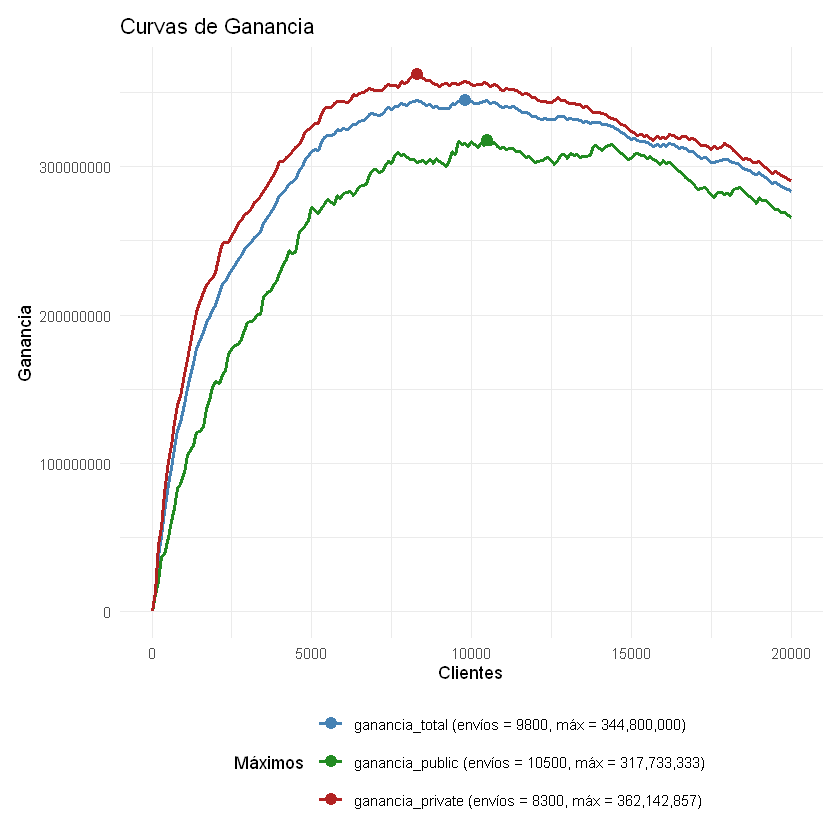

In [26]:
# pasamos a formato largo
resultados_long <- melt(
  resultados,
  id.vars = "clientes",
  measure.vars = c("ganancia_total", "ganancia_public", "ganancia_private"),
  variable.name = "tipo",
  value.name = "ganancia"
)

# calcular máximos por tipo
maximos <- resultados_long[, .SD[which.max(ganancia)], by = tipo]

# crear etiquetas personalizadas para la leyenda
etiquetas <- paste0(
  maximos$tipo,
  " (envíos = ", maximos$clientes, ", máx = ", format(maximos$ganancia, big.mark = ","), ")"
)
names(etiquetas) <- maximos$tipo

# gráfico
ggplot(resultados_long, aes(x = clientes, y = ganancia, color = tipo)) +
  geom_line(linewidth = 1) +
  # agregar puntos en los máximos
  geom_point(data = maximos, aes(x = clientes, y = ganancia, color = tipo), size = 3) +
  labs(
    title = "Curvas de Ganancia",
    x = "Clientes",
    y = "Ganancia",
    color = "Máximos"
  ) +
  scale_color_manual(values = c("ganancia_total" = "steelblue",
                                "ganancia_public" = "forestgreen",
                                "ganancia_private" = "firebrick"),
                     labels = etiquetas) +
  theme_minimal() +
  theme(
    plot.margin = margin(10, 10, 10, 10),  # top, right, bottom, left
    legend.position = "bottom")+
  guides(color = guide_legend(nrow = 3, byrow = TRUE))
  #+ ggsave("curvas.png", width = 10, height = 6)

In [ ]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "mar oct 07 14:37:22 2025"

: 

# Ensemble

In [ ]:
# Definir las 5 semillas fijas para el ensemble
semillas <- c(200003,300007,400009,500009,600011)

# Lista vacía para ir guardando la predicción de cada modelo
lista_predicciones <- list()

# clase01
dataset[, clase01 := ifelse(clase_ternaria %in% c("BAJA+1", "BAJA+2"), 1L, 0L)]

dataset_train <- dataset[foto_mes %in% PARAM$train_final]

# dejo los datos en el formato que necesita LightGBM
dtrain_final <- lgb.Dataset(
  data = data.matrix(dataset_train[, campos_buenos, with = FALSE]),
  label = dataset_train[, clase01]
)

# Entrenamiento final
param_final <- modifyList(PARAM$lgbm$param_fijos,
                          PARAM$out$lgbm$mejores_hiperparametros)

# este punto es muy SUTIL  y será revisado en la Clase 05
param_normalizado <- copy(param_final)
param_normalizado$min_data_in_leaf <- round(param_final$min_data_in_leaf / PARAM$trainingstrategy$undersampling)

# Dataset de predicción (lo definimos una sola vez fuera del bucle)
dfuture <- dataset[foto_mes %in% PARAM$future]

cat("Iniciando entrenamiento del ensamble con", length(semillas), "semillas...\n")

### Bucle para entrenar un modelo por cada semilla
for (semilla_actual in semillas) {
  print(paste0("\nEntrenando modelo con semilla: ", semilla_actual, "\n"))

  param_normalizado$seed <- semilla_actual
  
  # entreno LightGBM
  modelo_final <- lgb.train(
    data = dtrain_final,
    param = param_normalizado
  )
  
  # aplico el modelo a los datos nuevos
  prediccion_individual <- predict(
    modelo_final,
    data.matrix(dfuture[, campos_buenos, with = FALSE])
  )
  
  # Creamos una tabla con la predicción de esta semilla
  tb_prediccion_individual <- dfuture[, list(numero_de_cliente, foto_mes)] 
  tb_prediccion_individual[, prob := prediccion_individual]
  
  ### Guardamos la predicción en nuestra lista
  lista_predicciones[[as.character(semilla_actual)]] <- tb_prediccion_individual
  
} # Fin del bucle de semillas

cat("\nTodas las semillas procesadas. Creando el ensamble final...\n")

# Juntamos todas las tablas de la lista en una sola
predicciones_todas <- rbindlist(lista_predicciones)

# Agrupamos por cliente y calculamos la probabilidad promedio
tb_prediccion <- predicciones_todas[, .(prob = mean(prob)), by = .(numero_de_cliente, foto_mes)]

cat("Ensamble creado con éxito. Probabilidades promediadas.\n\n")

# inicilizo el dataset  drealidad
drealidad <- realidad_inicializar(dfuture, PARAM)

# ordeno por probabilidad descendente
setorder(tb_prediccion, -prob)

dir.create("kaggle_promedidado")
resultados <- data.table()

for (envios in PARAM$cortes) {
  
  tb_prediccion[, Predicted := 0L] # seteo inicial a 0
  tb_prediccion[1:envios, Predicted := 1L] # marco los primeros
  
  archivo_kaggle <- paste0("./kaggle_promedidado/", PARAM$experimento, "_", envios, ".csv")
  
  # grabo el archivo
  fwrite(tb_prediccion[, list(numero_de_cliente, Predicted)],
         file = archivo_kaggle,
         sep = ","
  )
  
  res <- realidad_evaluar(drealidad, tb_prediccion)
  resultados <- rbind(
    resultados,
    data.table(
      clientes = envios,
      ganancia_total = res$total,
      ganancia_public = res$public,
      ganancia_private = res$private
    )
  )
  
  options(scipen = 999)
  cat("Envios=", envios, "\t",
      " TOTAL=", res$total,
      "  Public=", res$public,
      "  Private=", res$private,
      "\n",
      sep = ""
  )
}

Iniciando entrenamiento del ensamble con 5 semillas...


In [ ]:
# pasamos a formato largo
resultados_long <- melt(
  resultados,
  id.vars = "clientes",
  measure.vars = c("ganancia_total", "ganancia_public", "ganancia_private"),
  variable.name = "tipo",
  value.name = "ganancia"
)

# calcular máximos por tipo
maximos <- resultados_long[, .SD[which.max(ganancia)], by = tipo]

# crear etiquetas personalizadas para la leyenda
etiquetas <- paste0(
  maximos$tipo,
  " (envíos = ", maximos$clientes, ", máx = ", format(maximos$ganancia, big.mark = ","), ")"
)
names(etiquetas) <- maximos$tipo

# gráfico
ggplot(resultados_long, aes(x = clientes, y = ganancia, color = tipo)) +
  geom_line(linewidth  = 1) +
  # agregar puntos en los máximos
  geom_point(data = maximos, aes(x = clientes, y = ganancia, color = tipo), size  = 3) +
  labs(
    title = "Curvas de Ganancia",
    x = "Clientes",
    y = "Ganancia",
    color = "Máximos"
  ) +
  scale_color_manual(values = c("ganancia_total" = "steelblue",
                                "ganancia_public" = "forestgreen",
                                "ganancia_private" = "firebrick"),
                     labels = etiquetas) +
  theme_minimal() +
  theme(
    plot.margin = margin(10, 10, 10, 10),  # top, right, bottom, left
    legend.position = "bottom")+
  guides(color = guide_legend(nrow = 3, byrow = TRUE))
  #+ ggsave("curvas_ensemble.png", width = 10, height = 6)